这份方案在kaggle比较中取得第43名，排名前2%，Inference推理时的模型选择采用了Stacking堆叠技术，在没有采用TTA，系数优化，伪标签等技术的情况下，取得这样的成绩还不错。

# General 概述
This is a not bad solution to get top2% without *TTA* or coefficient optimization.  
>[TTA（test time augmentation, 测试时增强）](https://blog.csdn.net/wydbyxr/article/details/84848903)  
可将准确率提高若干个百分点，它就是测试时增强（test time augmentation, TTA）。这里会为原始图像造出多个不同版本，包括不同区域裁剪和更改缩放程度等，并将它们输入到模型中；然后对多个版本进行计算得到平均输出，作为图像的最终输出分数。  
有作弊的嫌疑。  
这种技术很有效，因为原始图像显示的区域可能会缺少一些重要特征，在模型中输入图像的多个版本并取平均值，能解决上述问题。


**Training code has been put on [github](https://github.com/mikelkl/APTOS2019)**  
**[inference code](https://www.kaggle.com/mikelkl/43th-place-top2-solution-stacking-inference)** (Kaggle上的推理代码)  
**For detailed summary, please refer to [this blog](https://zhuanlan.zhihu.com/p/81695773)**  (知乎上的细节总结)

# Our Solution 我们的方案
## Data Augumentation 数据增强
-  Introduce [2015 Diabetic Retinopathy competition data](https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized)
- Conduct regular transformations that create less black padding 执行常规转换，以创建更少的黑色填充
  - do_flip
  - flip_vert
  - max_zoom
  
## Preprocessing 预处理
- Thanks to the [@Neuron Engineer](https://www.kaggle.com/ratthachat), we refer to his [APTOS [UpdatedV14] Preprocessing- Ben's & Cropping](https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping), and set `sigmaX=10`

## Pretrained Model 预训练模型
- We choose [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch) as our base model, this series model are quite accurate and fast to train.
>使用Ben的预处理算法，滤波去除光照影响并剪切去除黑边

## Training 训练
- Because this is a ordinal classification task, we train it as regression problem.由于这是一个有序分类任务，我们将其按回归问题训练
- We first pretrain model on 2015 data, then finetune on 2019 data. 先在2015数据上预训练模型，然后在2019数据上微调
>未提供私人数据库，提示用作者放在github上的训练代码，自己训练

## Ensemble 堆叠 
### Stage 1
- Train `efficientnet-b3, efficientnet-b4, efficientnet-b5` models on splitted 5-fold data resulting in 15 base models.

### Stage 2
- Train [xgboost](https://github.com/dmlc/xgboost), [svr](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), [catboost](https://github.com/catboost/catboost) models on logits output of stage 1 base model.

### Stage 3
- Bagging from stage 2 models

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd

import os
import cv2
import torch
import numpy as np

import sys
package_dir = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.insert(0, package_dir)

import efficientnet_pytorch 

from sklearn.metrics import cohen_kappa_score
from fastai.vision import *
from torch.nn import functional as F
import time
import pickle as pk

#time clock counting
start = time.time()

/home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 999
seed_everything(SEED)

In [3]:
# 最佳模型文件的目录
deployment_dir = "../output/inference"

# kappa系数
def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')  # 读入测试文件

# Preprocess Image and save on disk

测试样本需要进行与训练样本相同的预处理过程，存入指定的磁盘位置

In [4]:
from tqdm.notebook import tqdm

from PIL import Image
import multiprocessing as mp

# 切剪图像
def crop_image_from_gray(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            # print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
            # print(img.shape)
        return img

# 加载图像并完成预处理
IMG_SIZE = 512
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)  # 读入图像
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #颜色通道变换
    image = crop_image_from_gray(image)  # 切剪图像
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # 尺寸变换
    image=cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)  # 去除光照影响
        
    return image

# 读入原图，完成预处理后保存到指定位置
def process(q, iolock):
    while True:
        stuff = q.get()
        if stuff is None:
            break
        idx, row = stuff
        path=f"../input/aptos2019-blindness-detection/test_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=10)  # 加载图像并完成预处理
        Image.fromarray(image).save(os.path.join(save_dir, "{}.png".format(row['id_code'])))  # 保存图像

In [5]:
# 保存图像路径
save_dir = "../input/aptos2019-blindness-detection/test_images_ben_preprocessing_sigmaX10(2)"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [6]:
sv_t1 = time.time()
NCORE = 20  # 使用20个处理器线程并行处理
q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))
for idx, row in tqdm(test_df.iterrows()):
    stuff = (idx, row)
    q.put(stuff)  # blocks until q below its max size
for _ in range(NCORE):  # tell workers we're done
    q.put(None)
pool.close()
pool.join()  
sv_t2 = time.time()
sv_dur = sv_t2 - sv_t1
print('Preprocessing and save takes time ... {} seconds , {} hours'.format(sv_dur,sv_dur/3600))
# 原 Preprocessing and save takes time ... 357.6067280769348 seconds , 0.099335202243593 hours


Preprocessing and save takes time ... 172.14638113975525 seconds , 0.04781843920548757 hours


In [9]:
# du命令(参数sh表示按人阅读的方式按总体计算) 显示文件或目录所占用的磁盘空间
# !du -sh '../input/aptos2019-blindness-detection/test_images_ben_preprocessing_sigmaX10(2)'  # 原580M	../input/test_images_ben_preprocessing_sigmaX10

580M	../input/aptos2019-blindness-detection/test_images_ben_preprocessing_sigmaX10(2)


# Stage1&2 Inference 步骤1&2 推理

测试集进行预测和评估

(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)


(1928, 1)
[15:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


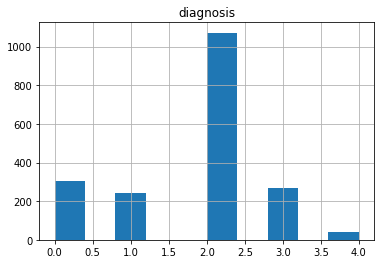

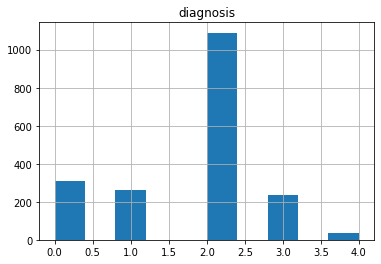

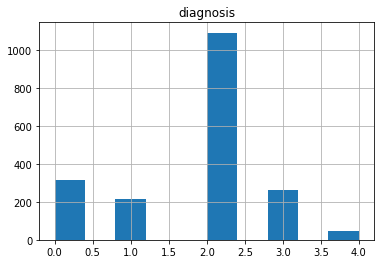

Inference duration  376.38926935195923 0.10455257481998867


In [11]:
inf1_t1 = time.time()

# 使用阶段二生成的最佳模型，预测测试集
b3_models = ["efficientnet-b3_1202_14-10-24_stage2_f1", 
             "efficientnet-b3_1202_14-10-24_stage2_f2",
             "efficientnet-b3_1202_14-10-24_stage2_f3", 
             "efficientnet-b3_1202_14-10-24_stage2_f4",
             "efficientnet-b3_1202_14-10-24_stage2_f5"]

b3_test_logits_list = []
for m in b3_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b3_test_logits_list.append(logits)
    
    print(logits.shape)


b4_models = ["efficientnet-b4_1202_14-10-24_stage2_f1", 
             "efficientnet-b4_1202_14-10-24_stage2_f2",
             "efficientnet-b4_1202_14-10-24_stage2_f3", 
             "efficientnet-b4_1202_14-10-24_stage2_f4",
             "efficientnet-b4_1202_14-10-24_stage2_f5"]

b4_test_logits_list = []
for m in b4_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b4_test_logits_list.append(logits)
    
    print(logits.shape)
    

b5_models = ["efficientnet-b5_1202_14-10-24_stage2_f1", 
             "efficientnet-b5_1202_14-10-24_stage2_f2",
             "efficientnet-b5_1202_14-10-24_stage2_f3", 
             "efficientnet-b5_1202_14-10-24_stage2_f4",
             "efficientnet-b5_1202_14-10-24_stage2_f5"]

b5_test_logits_list = []
for m in b5_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b5_test_logits_list.append(logits)
    
    print(logits.shape)

# 加载grid对象，各自包含某种提升评估器，以及经过网格搜索得到最佳超参数
with open(os.path.join(deployment_dir, "xgboost-1202_14-10-24.pkl"), "rb") as f:
    xlf = pk.load(f)
    
with open(os.path.join(deployment_dir, "svr-1202_14-10-24.pkl"), "rb") as f:
    svr = pk.load(f)

with open(os.path.join(deployment_dir, "cb-1202_14-10-24.pkl"), "rb") as f:
    cb = pk.load(f)

# b3,b4,b5系列模型，在2015数据集中训练后，又在2019年数据集中进行了5折交叉验证训练
# 2019的测试集，在这些模型上预测得到预测值，预测值由已搜索到最佳超参数的评估器整合
# 5 test feature then avg
results_xlf = []
results_svr = []
results_cb = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    
    res_xlf = xlf.predict(X_test)
    results_xlf.append(res_xlf)
    
    res_svr = svr.predict(X_test)
    results_svr.append(res_svr)
    
    res_cb = cb.predict(X_test)
    results_cb.append(res_cb)

# 平均
avg_res_xlf = np.average(results_xlf, axis=0)
avg_res_svr = np.average(results_svr, axis=0)
avg_res_cb = np.average(results_cb, axis=0)

# 数据类型转换
y_pred_xlf = np.round(avg_res_xlf).astype(int)
y_pred_svr = np.round(avg_res_svr).astype(int)
y_pred_cb = np.round(avg_res_cb).astype(int)

test_df.diagnosis = y_pred_xlf
test_df.hist()
plt.show()

test_df.diagnosis = y_pred_svr
test_df.hist()
plt.show()

test_df.diagnosis = y_pred_cb
test_df.hist()
plt.show()

# 计算推理过程的时间消耗
inf1_t2 = time.time()
inf1_dur = inf1_t2 - inf1_t1
print('Inference duration ',inf1_dur, inf1_dur/3600)
# (1928, 1)
# [03:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Inference duration  349.231999874115 0.09700888885392082

(1928, 1)
[03:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


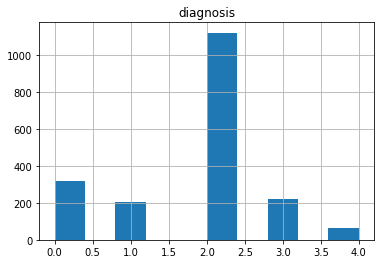

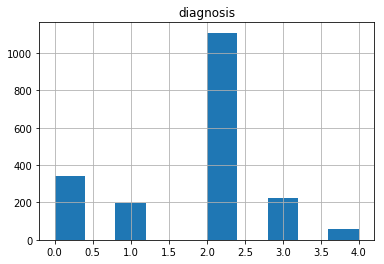

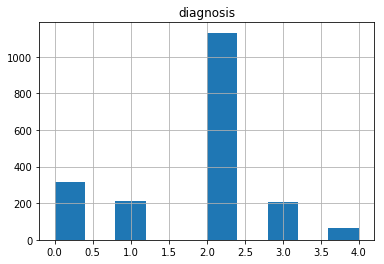

Inference duration  349.231999874115 0.09700888885392082


In [8]:
inf1_t1 = time.time()

# 使用阶段二生成的最佳模型，预测测试集
b3_models = ["efficientnet-b3_1202_14-10-24_stage2_f1", 
             "efficientnet-b3_1202_14-10-24_stage2_f2",
             "efficientnet-b3_1202_14-10-24_stage2_f3", 
             "efficientnet-b3_1202_14-10-24_stage2_f4",
             "efficientnet-b3_1202_14-10-24_stage2_f5"]

b3_test_logits_list = []
for m in b3_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b3_test_logits_list.append(logits)
    
    print(logits.shape)


b4_models = ["efficientnet-b4_1202_14-10-24_stage2_f1", 
             "efficientnet-b4_1202_14-10-24_stage2_f2",
             "efficientnet-b4_1202_14-10-24_stage2_f3", 
             "efficientnet-b4_1202_14-10-24_stage2_f4",
             "efficientnet-b4_1202_14-10-24_stage2_f5"]

b4_test_logits_list = []
for m in b4_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b4_test_logits_list.append(logits)
    
    print(logits.shape)
    

b5_models = ["efficientnet-b5_1202_14-10-24_stage2_f1", 
             "efficientnet-b5_1202_14-10-24_stage2_f2",
             "efficientnet-b5_1202_14-10-24_stage2_f3", 
             "efficientnet-b5_1202_14-10-24_stage2_f4",
             "efficientnet-b5_1202_14-10-24_stage2_f5"]

b5_test_logits_list = []
for m in b5_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b5_test_logits_list.append(logits)
    
    print(logits.shape)

# 加载grid对象，各自包含某种提升评估器，以及经过网格搜索得到最佳超参数
with open(os.path.join(deployment_dir, "xgboost-1202_14-10-24.pkl"), "rb") as f:
    xlf = pk.load(f)
    
with open(os.path.join(deployment_dir, "svr-1202_14-10-24.pkl"), "rb") as f:
    svr = pk.load(f)

with open(os.path.join(deployment_dir, "cb-1202_14-10-24.pkl"), "rb") as f:
    cb = pk.load(f)

# b3,b4,b5系列模型，在2015数据集中训练后，又在2019年数据集中进行了5折交叉验证训练
# 2019的测试集，在这些模型上预测得到预测值，预测值由已搜索到最佳超参数的评估器整合
# 5 test feature then avg
results_xlf = []
results_svr = []
results_cb = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    
    res_xlf = xlf.predict(X_test)
    results_xlf.append(res_xlf)
    
    res_svr = svr.predict(X_test)
    results_svr.append(res_svr)
    
    res_cb = cb.predict(X_test)
    results_cb.append(res_cb)

# 平均
avg_res_xlf = np.average(results_xlf, axis=0)
avg_res_svr = np.average(results_svr, axis=0)
avg_res_cb = np.average(results_cb, axis=0)

# 数据类型转换
y_pred_xlf = np.round(avg_res_xlf).astype(int)
y_pred_svr = np.round(avg_res_svr).astype(int)
y_pred_cb = np.round(avg_res_cb).astype(int)

test_df.diagnosis = y_pred_xlf
test_df.hist()
plt.show()

test_df.diagnosis = y_pred_svr
test_df.hist()
plt.show()

test_df.diagnosis = y_pred_cb
test_df.hist()
plt.show()

# 计算推理过程的时间消耗
inf1_t2 = time.time()
inf1_dur = inf1_t2 - inf1_t1
print('Inference duration ',inf1_dur, inf1_dur/3600)
# (1928, 1)
# [03:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Inference duration  349.231999874115 0.09700888885392082

# Stage3 Bagging 步骤3装袋

## Correlation Analysis 相关性分析

In [12]:
np.corrcoef([avg_res_xlf, avg_res_svr, avg_res_cb])
# array([[1.      , 0.997143, 0.997563],
#        [0.997143, 1.      , 0.998309],
#        [0.997563, 0.998309, 1.      ]])

array([[1.      , 0.996956, 0.998737],
       [0.996956, 1.      , 0.996665],
       [0.998737, 0.996665, 1.      ]])

In [13]:
np.corrcoef([y_pred_xlf, y_pred_svr, y_pred_cb])
# array([[1.      , 0.975527, 0.978376],
#        [0.975527, 1.      , 0.983601],
#        [0.978376, 0.983601, 1.      ]])

array([[1.      , 0.97545 , 0.984835],
       [0.97545 , 1.      , 0.973508],
       [0.984835, 0.973508, 1.      ]])

In [14]:
def voting(labels, Tweights = None):
    if isinstance(labels, list):
        X = np.array(labels, dtype=np.int64)   
        maj = np.argmax(np.bincount(X, Tweights))
    return maj

def average(logits, Tweights = None):
    avg = np.average(logits, axis=0, weights = Tweights)
    return avg

In [15]:
# 投票决定最终分级
vote_list = [voting([int(avg_res_xlf[idx] + 0.5), 
                    int(avg_res_svr[idx] + 0.5), 
                    int(avg_res_cb[idx] + 0.5)]) 
             for idx in range(len(avg_res_xlf))]

# Submission 提交

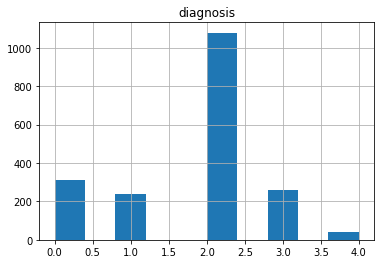

In [16]:
test_df.diagnosis = vote_list
test_df.hist()
plt.show()

test_df.to_csv('submission.csv',index=False)

In [17]:
test_df['diagnosis'].value_counts()
# 2    1122
# 0     323
# 3     210
# 1     209
# 4      64

2    1078
0     310
3     261
1     238
4      41
Name: diagnosis, dtype: int64

In [18]:
dur = time.time() -start
print('Whole procedure takes {} seconds long ...'.format(dur))
print(dur/3600)
print ('done')
# Whole procedure takes 710.5857803821564 seconds long ...
# 0.19738493899504345
# done

Whole procedure takes 4852.177564382553 seconds long ...
1.347827101217376
done
